In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST

from neuralforecast.losses.numpy import mae, mse

from nixtlats import TimeGPT

%matplotlib inline

In [2]:
with open("data/timegpt_api_key.txt", 'r') as file:
        API_KEY = file.read()

## Read data 

In [3]:
df = pd.read_csv('data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


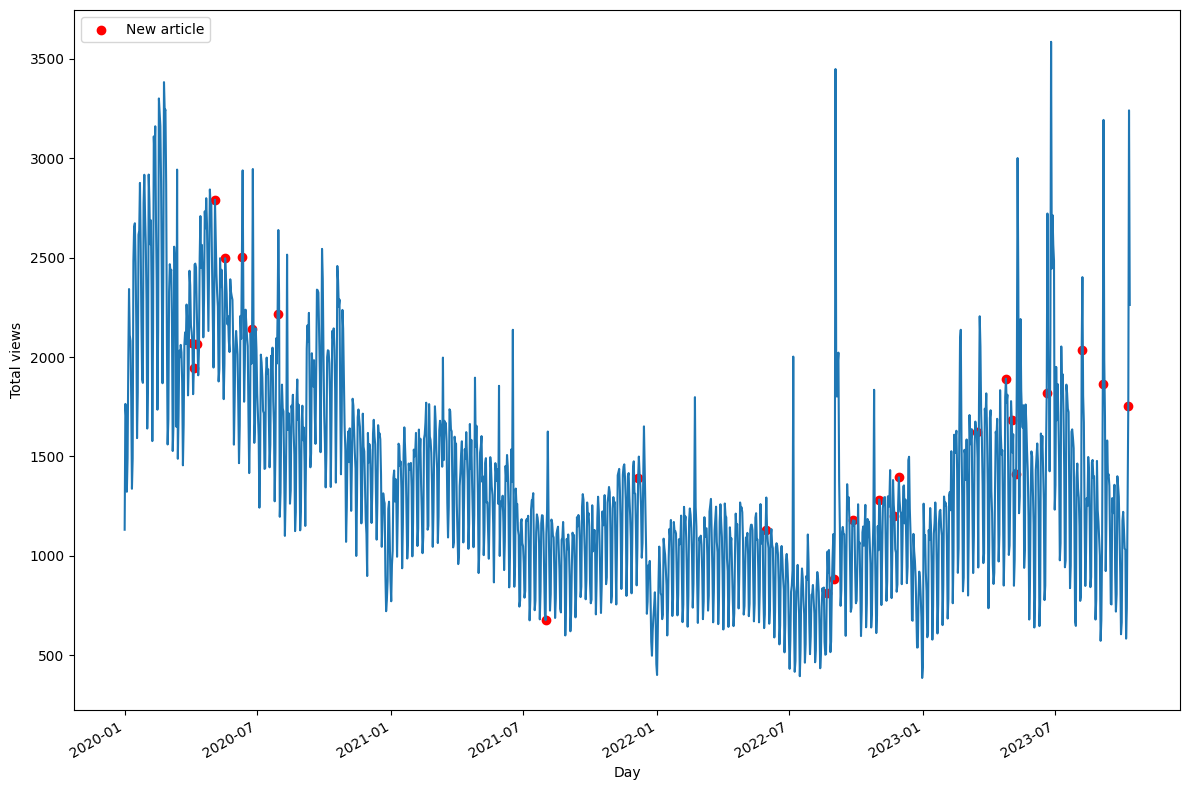

In [4]:
published_dates = df[df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()


plt.tight_layout()

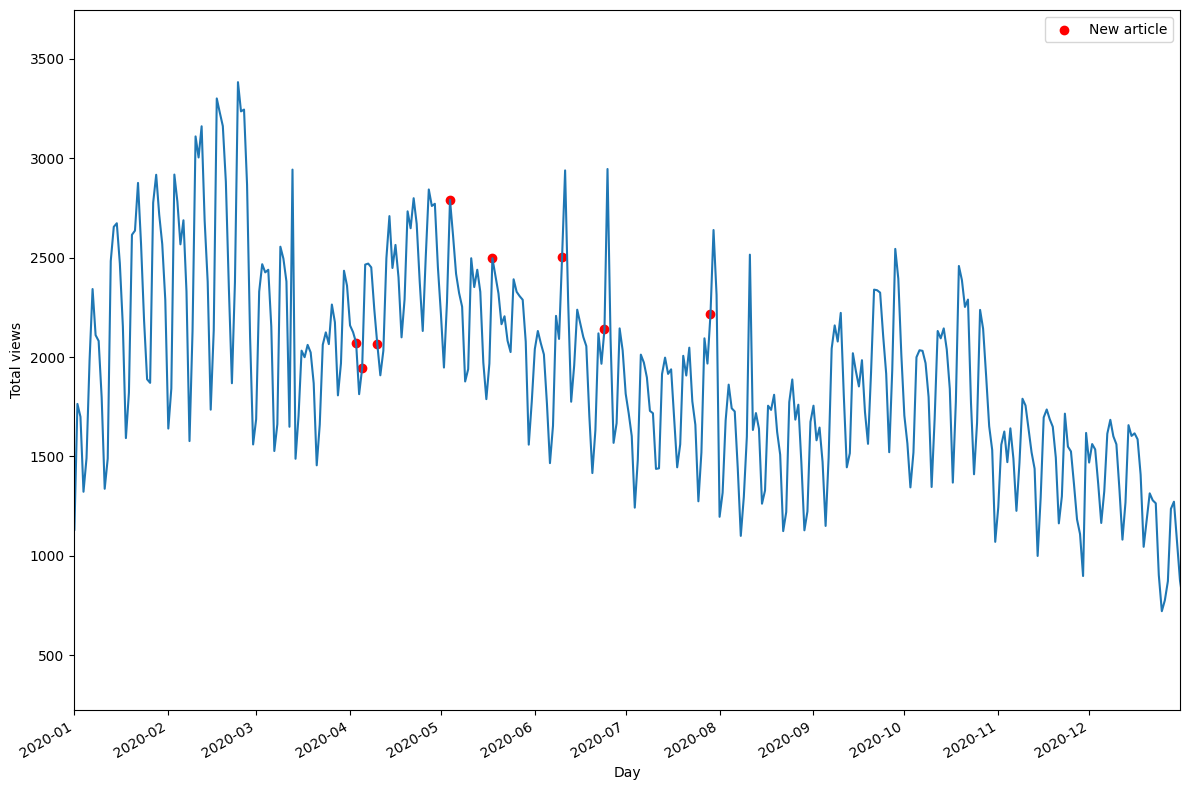

In [5]:
published_dates = df[df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')
ax.set_xlim([datetime.date(2020, 1, 1), datetime.date(2020, 12, 31)])

fig.autofmt_xdate()


plt.tight_layout()

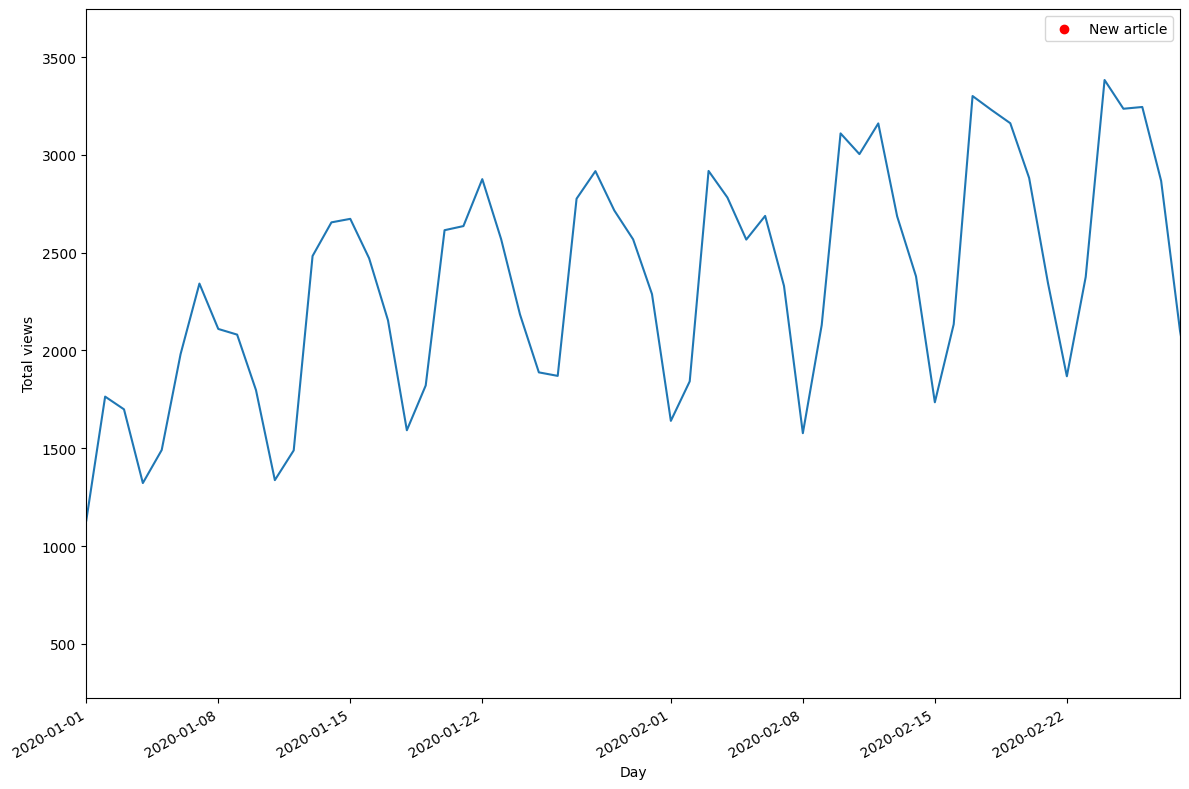

In [6]:
published_dates = df[df['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df['ds'], df['y'])
ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')
ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')
ax.set_xlim([datetime.date(2020, 1, 1), datetime.date(2020, 2, 28)])

fig.autofmt_xdate()


plt.tight_layout()

## TimeGPT 

In [7]:
train = df[:-168]
test = df[-168:]

print(train.shape)
print(test.shape)

(1213, 5)
(168, 5)


In [17]:
df.iloc[:1213]

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0
...,...,...,...,...,...
1208,0,2023-04-23,1049,0.0,0
1209,0,2023-04-24,1798,0.0,0
1210,0,2023-04-25,1891,1.0,0
1211,0,2023-04-26,1771,0.0,0


In [14]:
future_exog = test[['unique_id', 'ds', 'published', 'is_holiday']]

In [19]:
timegpt = TimeGPT(token=API_KEY)

timegpt_preds = []

for i in range(0, 162, 7):

    timegpt_preds_df = timegpt.forecast(
        df=df.iloc[:1213+i],
        X_df = future_exog[i:i+7],
        h=7,
        finetune_steps=10,
        id_col='unique_id',
        time_col='ds',
        target_col='y'
    )
    
    preds = timegpt_preds_df['TimeGPT']
    
    timegpt_preds.extend(preds)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endp

In [20]:
len(timegpt_preds)

168

In [22]:
test['TimeGPT'] = timegpt_preds

test.head()

,unique_id,ds,y,published,is_holiday,TimeGPT
1213,0,2023-04-28,1470,0.0,0,1408.415761
1214,0,2023-04-29,1004,0.0,0,910.132924
1215,0,2023-04-30,1051,0.0,0,1134.113088
1216,0,2023-05-01,1333,0.0,0,1772.543080
1217,0,2023-05-02,1778,0.0,0,1778.654775


In [26]:
test.to_csv('medium_views_test.csv', header=True, index=False)

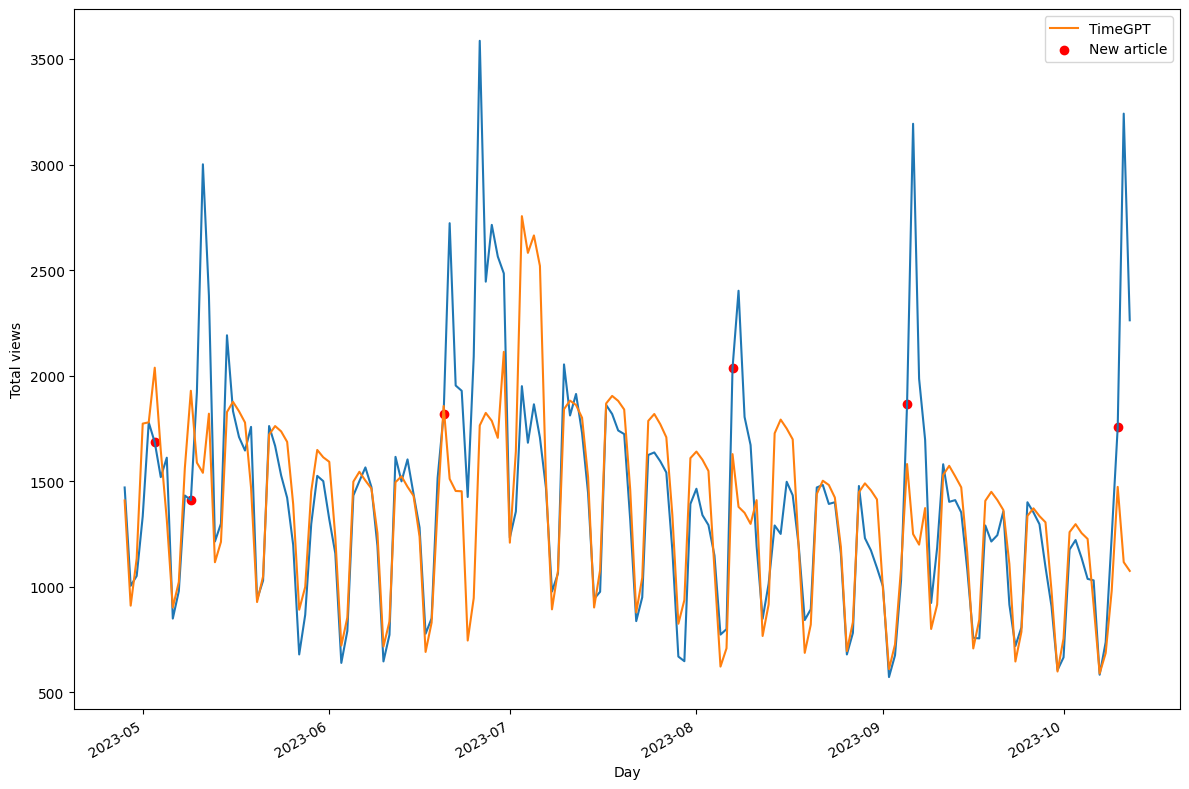

In [25]:
published_dates = test[test['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(test['ds'], test['y'])
ax.plot(test['ds'], test['TimeGPT'], label='TimeGPT')

ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')

ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()

plt.tight_layout()

In [4]:
test = pd.read_csv('medium_views_test.csv')
test.head()

,unique_id,ds,y,published,is_holiday,TimeGPT
0,0,2023-04-28,1470,0.0,0,1408.415761
1,0,2023-04-29,1004,0.0,0,910.132924
2,0,2023-04-30,1051,0.0,0,1134.113088
3,0,2023-05-01,1333,0.0,0,1772.543080
4,0,2023-05-02,1778,0.0,0,1778.654775


In [5]:
horizon = 7

models = [NHITS(h=horizon,
               input_size=5*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=5*horizon,
               max_steps=50),
         PatchTST(h=horizon,
                 input_size=5*horizon,
                 max_steps=50)]

Global seed set to 1
Global seed set to 1
Global seed set to 1


In [6]:
nf = NeuralForecast(models=models, freq='D')

In [7]:
future_exog = test[['unique_id', 'published', 'is_holiday']]

preds_df = nf.cross_validation(df=df, static_df=future_exog , step_size=7, n_windows=24)

Epoch 49: 100%|█████████████████| 1/1 [00:00<00:00,  9.43it/s, v_num=85, train_loss_step=143.0, train_loss_epoch=141.0]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|█████████████████| 1/1 [00:00<00:00, 10.64it/s, v_num=87, train_loss_step=125.0, train_loss_epoch=124.0]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|█████████████████| 1/1 [00:00<00:00,  2.12it/s, v_num=89, train_loss_step=157.0, train_loss_epoch=154.0]
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.31it/s]


In [8]:
preds_df

,unique_id,ds,cutoff,NHITS,NBEATS,PatchTST,y,published,is_holiday
0,0,2023-04-28,2023-04-27,1573.291626,1474.000000,1481.889526,1470,0.0,0
1,0,2023-04-29,2023-04-27,1202.700195,1007.759521,1107.362183,1004,0.0,0
2,0,2023-04-30,2023-04-27,1309.106079,1202.114624,1199.866455,1051,0.0,0
3,0,2023-05-01,2023-04-27,1815.835205,1819.108643,1768.995850,1333,0.0,0
4,0,2023-05-02,2023-04-27,1955.815796,1840.209717,1846.371704,1778,0.0,0
...,...,...,...,...,...,...,...,...,...
163,0,2023-10-08,2023-10-05,534.412415,707.846558,606.114136,737,0.0,0
164,0,2023-10-09,2023-10-05,955.028625,1079.107544,1064.485352,1237,0.0,1
165,0,2023-10-10,2023-10-05,1181.412231,1193.030151,1171.253418,1755,1.0,0
166,0,2023-10-11,2023-10-05,1143.975830,1223.471924,1087.540283,3241,0.0,0


In [9]:
preds_df['TimeGPT'] = test['TimeGPT']
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,PatchTST,y,published,is_holiday,TimeGPT
0,0,2023-04-28,2023-04-27,1573.291626,1474.000000,1481.889526,1470,0.0,0,1408.415761
1,0,2023-04-29,2023-04-27,1202.700195,1007.759521,1107.362183,1004,0.0,0,910.132924
2,0,2023-04-30,2023-04-27,1309.106079,1202.114624,1199.866455,1051,0.0,0,1134.113088
3,0,2023-05-01,2023-04-27,1815.835205,1819.108643,1768.995850,1333,0.0,0,1772.543080
4,0,2023-05-02,2023-04-27,1955.815796,1840.209717,1846.371704,1778,0.0,0,1778.654775


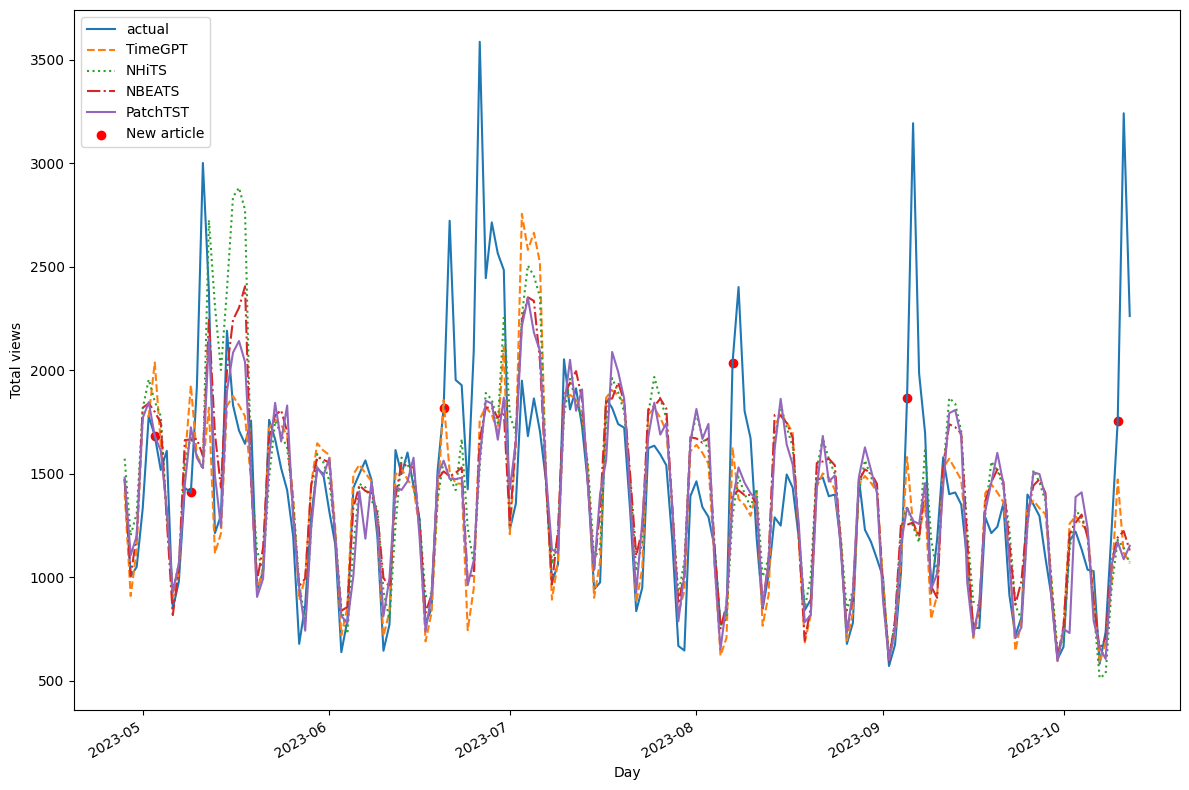

In [11]:
published_dates = test[test['published'] == 1]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(preds_df['ds'], preds_df['y'], label='actual')
ax.plot(preds_df['ds'], preds_df['TimeGPT'], ls='--', label='TimeGPT')
ax.plot(preds_df['ds'], preds_df['NHITS'], ls=':', label='NHiTS')
ax.plot(preds_df['ds'], preds_df['NBEATS'], ls='-.', label='NBEATS')
ax.plot(preds_df['ds'], preds_df['PatchTST'], ls='-', label='PatchTST')

ax.scatter(published_dates['ds'], published_dates['y'], marker='o', color='red', label='New article')

ax.set_xlabel('Day')
ax.set_ylabel('Total views')
ax.legend(loc='best')

fig.autofmt_xdate()

plt.tight_layout()

## Evaluation 

In [12]:
preds_df = preds_df.round({
    'NHITS': 0,
    'NBEATS': 0,
    'PatchTST': 0,
    'TimeGPT': 0
})

preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,PatchTST,y,published,is_holiday,TimeGPT
0,0,2023-04-28,2023-04-27,1573.0,1474.0,1482.0,1470,0.0,0,1408.0
1,0,2023-04-29,2023-04-27,1203.0,1008.0,1107.0,1004,0.0,0,910.0
2,0,2023-04-30,2023-04-27,1309.0,1202.0,1200.0,1051,0.0,0,1134.0
3,0,2023-05-01,2023-04-27,1816.0,1819.0,1769.0,1333,0.0,0,1773.0
4,0,2023-05-02,2023-04-27,1956.0,1840.0,1846.0,1778,0.0,0,1779.0


In [13]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'PatchTST': [mae(preds_df['PatchTST'], preds_df['y']), mse(preds_df['PatchTST'], preds_df['y'])],
       'TimeGPT': [mae(preds_df['TimeGPT'], preds_df['y']), mse(preds_df['TimeGPT'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,PatchTST,TimeGPT
mae,298.994048,266.238095,268.023810,242.904762
mse,218605.910714,182097.738095,184486.595238,180443.964286
